# Hometask 02
### Maksim Sorokin

Проверить состояние датафрейма и привести его в формат, позволяющий дальнейшее исследование данных:
- Привести колонки датафрейма к одному типу данных
- Проверить индекс, чтобы он соответствовал порядку строк
- Проверить наличие пропусков и в случае обнаружения, определить стратегию их обработки

In [221]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [148]:
df = pd.read_excel('output/dom_objects.xlsx')


Для исследования в задании 3 необходимы следюущие столбцы из "сырого" массива загруженных из api данных,
поэтому типы данных и пропуски данных буду смотреть только в тех столбцах, что представляют интерес в целях исследования
- регион
- средняя цена за квадратный метр
- объем вводимого жилья
- год ввода в эксплуатацию
- этажность
- количество квартир
- жилая площадь 
- количество парковочных мест

In [162]:
assert df.region.dtype == 'int64'           # регион
assert df.objPriceAvg.dtype == 'float64'    # средняя цена за квадратный метр
## здесь лежит object, его надо конвертировать
df.objReady100PercDt = pd.to_datetime(df.objReady100PercDt, format='%Y-%m-%d')
assert df.objSquareLiving.dtype == 'float64'    # жилая площадь (самое подходящее поле для "Объема вводимого жилья")
assert df.floorMax.dtype == 'float64'                 # этажность
assert df.objReady100PercDt.dtype == 'datetime64[ns]' # дата ввода в эксплуатацию
assert df.objFlatCnt.dtype == 'int64'       # количество квартир
assert df.objElemParkingCnt.dtype =='int64' # объем парковочных мест

columns_for_research = set()
columns_for_research.update(['region','objPriceAvg','objReady100PercDt', 'objSquareLiving', 'floorMax', 'objFlatCnt', df.objElemParkingCnt.name])
print(df.objElemParkingCnt.name)

objElemParkingCnt


Отбрасываю неинтересующую меня информацию, проверяю индекс

In [163]:
df2 = df
for a in df.columns:
    if a  not in columns_for_research: 
        df2 = df2.drop(labels=a, axis=1)


assert df2.index.is_unique
df2.shape
df2.head(3)
df2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10660 entries, 0 to 10659
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   region             10660 non-null  int64         
 1   objReady100PercDt  10660 non-null  datetime64[ns]
 2   objElemParkingCnt  10660 non-null  int64         
 3   objSquareLiving    10660 non-null  float64       
 4   objFlatCnt         10660 non-null  int64         
 5   floorMax           10659 non-null  float64       
 6   objPriceAvg        7608 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 583.1 KB


Видим, большой датафрейм с полным набором занимал 5.4+ MB, а датафрейм с только интересующими нас данными - 499.8 KB
Так же по выводу info видимо, что пустые значения есть в столбцах floorMax & objPriceAvg, считаю их:

In [166]:
df2.isnull().sum()

region                  0
objReady100PercDt       0
objElemParkingCnt       0
objSquareLiving         0
objFlatCnt              0
floorMax                1
objPriceAvg          3052
dtype: int64

Заменяю единственный пропуск в этажности на среднее значение, контролирую результат

In [167]:

df_fill_na_floor = df2.fillna({'floorMax': df2.floorMax.mean()})
df_fill_na_floor.isnull().sum()

region                  0
objReady100PercDt       0
objElemParkingCnt       0
objSquareLiving         0
objFlatCnt              0
floorMax                0
objPriceAvg          3052
dtype: int64

А вот с ценой - вычищаю эти строки совсем, проверяю результат

In [168]:
final_df = df_fill_na_floor.dropna(how='any')
final_df.shape

(7608, 7)

Сохраняю рафинированный датафрейм для исследования в рамках следующего задания

In [169]:
final_df.to_pickle("output/dom_refined.pkl")

### Провести мини-исследование рынка строящейся недвижимости в одном или нескольких регионах с помощью pandas, matplotlib, seaborn, plotly и других инструментов.

– Рассчитать средние цены за квадратный метр по регионам. Важно чтобы пропуски не учитывались при расчете средней цены.

In [170]:
regions_df = pd.read_csv('regions.csv')   # нашел справочник тут https://github.com/hflabs/region/blob/master/region.csv, сделаю "по-красоте"
assert regions_df.kladr_id.dtype == 'int64'

In [171]:
d = dict()
for a in regions_df.kladr_id:
    d[a/100000000000] = regions_df.loc[regions_df.kladr_id == a]['name_with_type'].to_string(index=False)

In [172]:
final_df['region_str'] = final_df["region"].map(d)
final_df['year'] = pd.DatetimeIndex(final_df['objReady100PercDt']).year
final_df.head(3)

/var/folders/m5/pv26hd813_bbqw43lz3r1n1rhpvc8t/T/ipykernel_82965/2246262962.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['region_str'] = final_df["region"].map(d)
/var/folders/m5/pv26hd813_bbqw43lz3r1n1rhpvc8t/T/ipykernel_82965/2246262962.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['year'] = pd.DatetimeIndex(final_df['objReady100PercDt']).year


,region,objReady100PercDt,objElemParkingCnt,objSquareLiving,objFlatCnt,floorMax,objPriceAvg,region_str,year
1,72,2024-12-31,0,6248.51,65,12.0,45523.0,Тюменская обл,2024
2,72,2024-12-31,0,4812.98,43,10.0,47886.0,Тюменская обл,2024
3,72,2022-12-31,31,6293.78,68,20.0,53109.0,Тюменская обл,2022


In [173]:
final_df.pivot_table(columns = 'region_str', values='objPriceAvg', aggfunc='mean').mean()


region_str
Алтайский край        69779.055556
Амурская обл         116050.863636
Архангельская обл     82845.894737
Астраханская обл      78524.724138
Белгородская обл      79231.733333
                         ...      
Ямало-Ненецкий АО     92141.227273
Ярославская обл       67754.507042
г Москва             315360.371642
г Санкт-Петербург    171468.330396
г Севастополь        117498.590909
Length: 78, dtype: float64

– Рассчитать объемы вводимого жилья по регионам и по годам.

In [174]:
final_df.pivot_table(columns = ['region_str','year'], values='objSquareLiving', aggfunc='sum').sum()

region_str         year
Алтайский край     2022    102658.43
                   2023    239547.73
                   2024    135937.59
                   2025     71951.00
                   2026     15482.25
                             ...    
г Санкт-Петербург  2026         0.00
г Севастополь      2022     20820.01
                   2023     10342.42
                   2024     17520.54
                   2025     50201.71
Length: 339, dtype: float64

– Сравнить этажность домов, количество квартир, жилую площадь, количество парковочных мест и цену за квадратный метр в разных регионах

floorMax


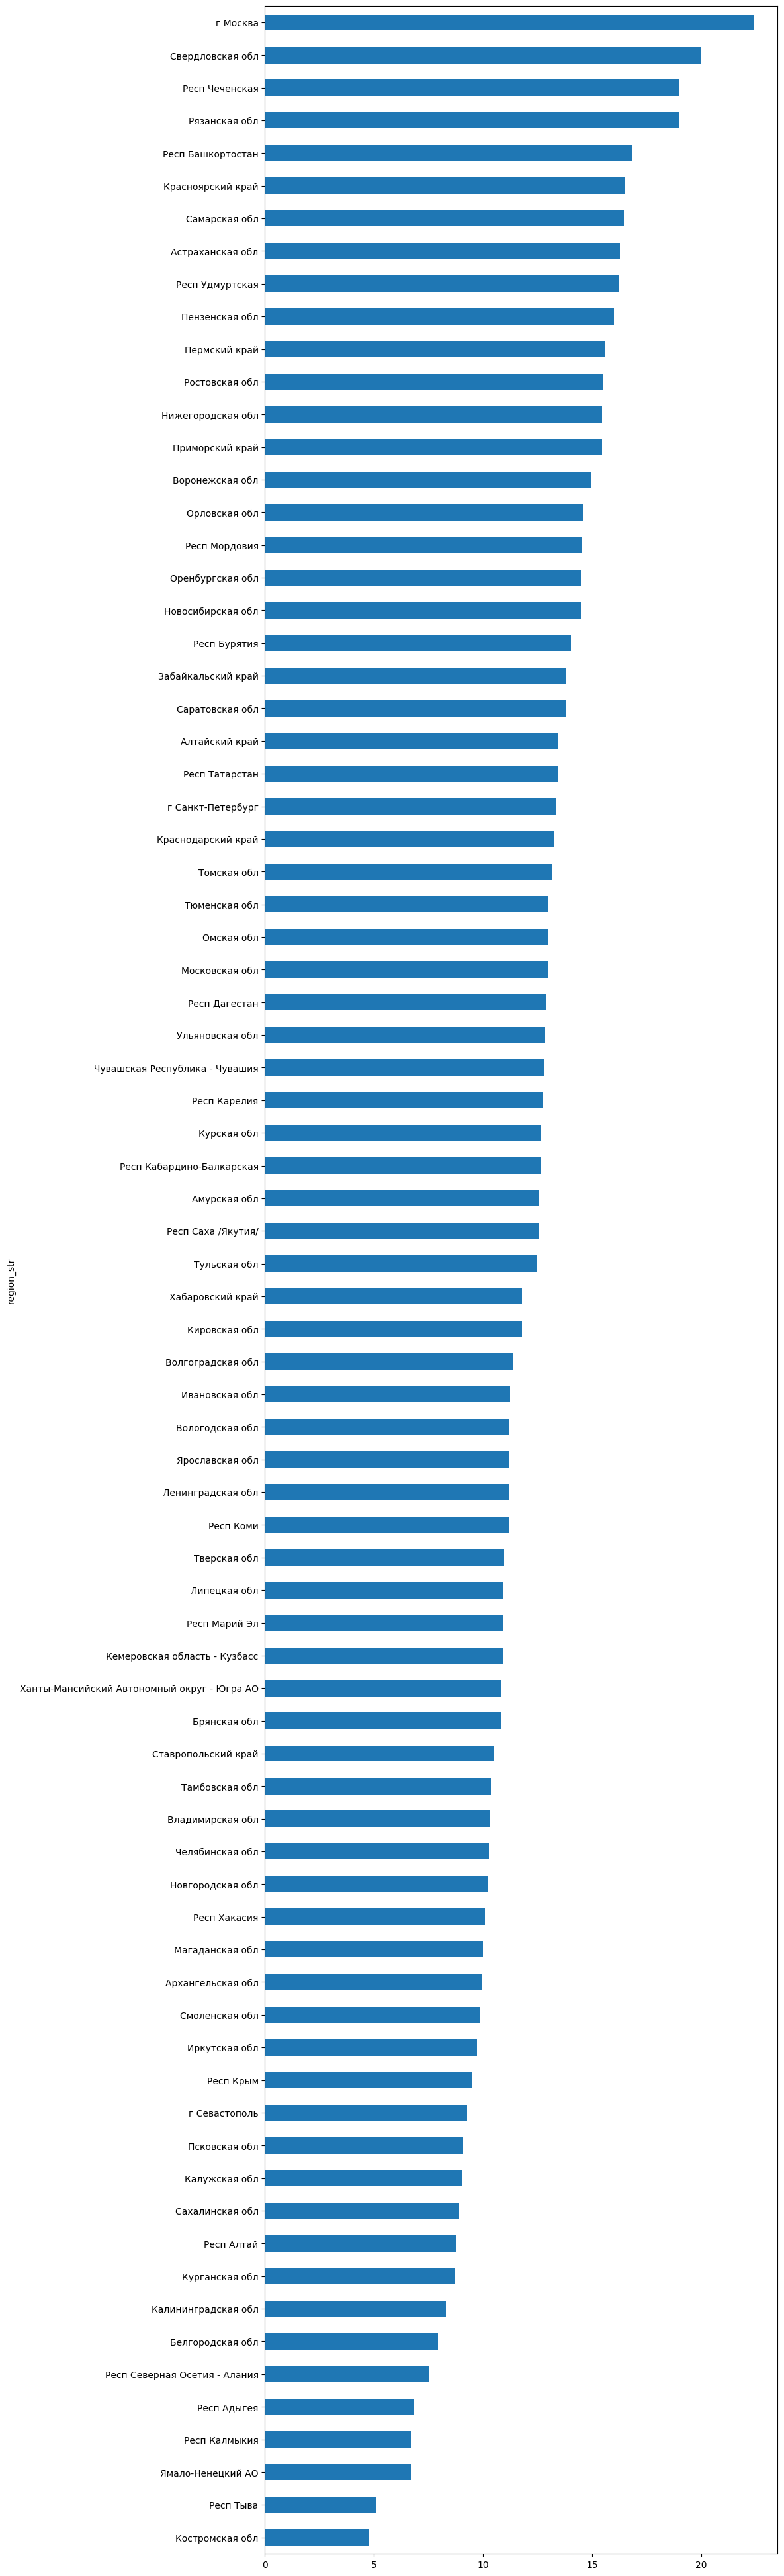

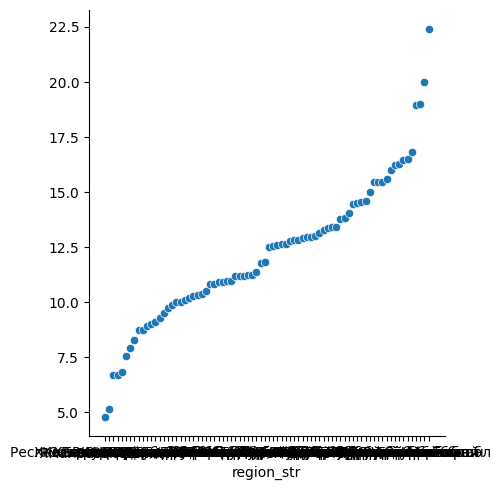

objFlatCnt


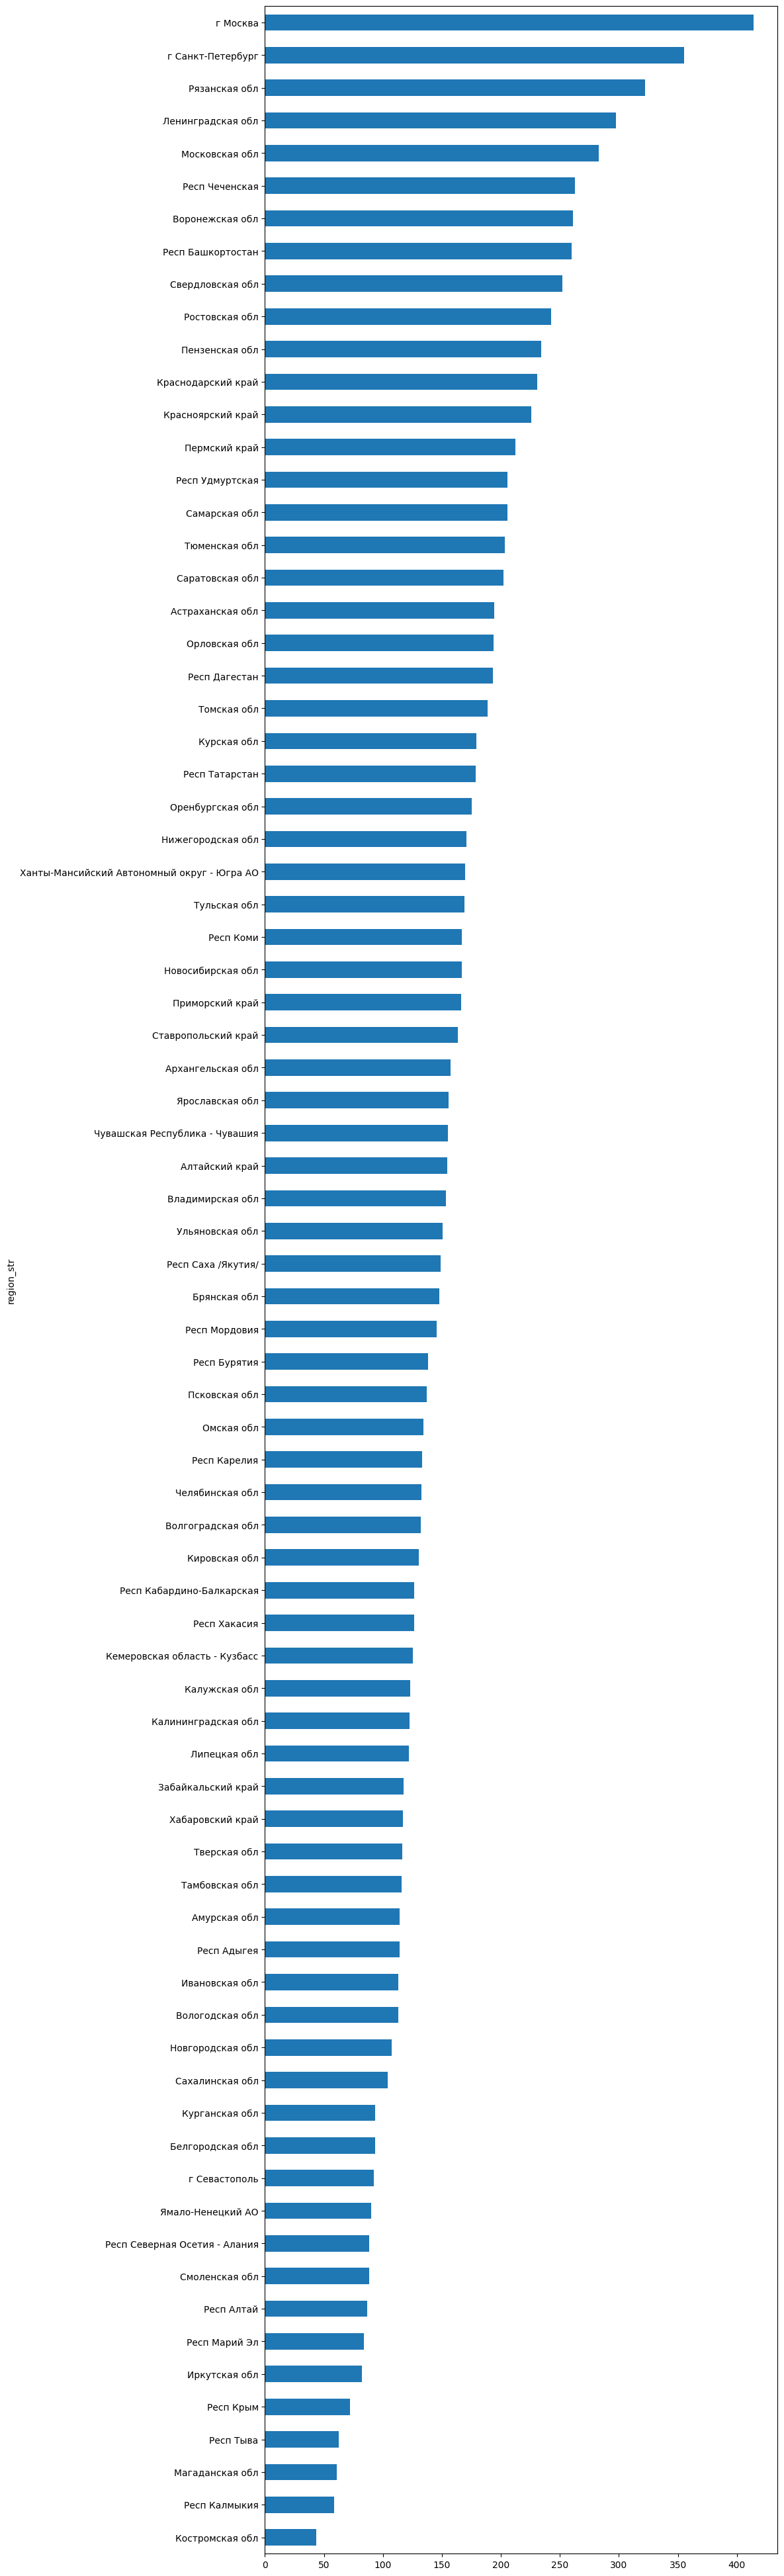

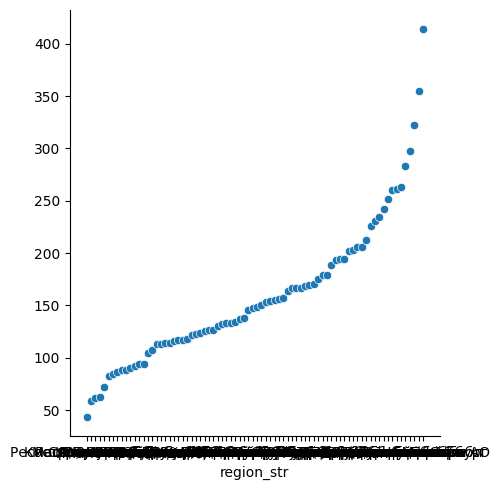

objPriceAvg


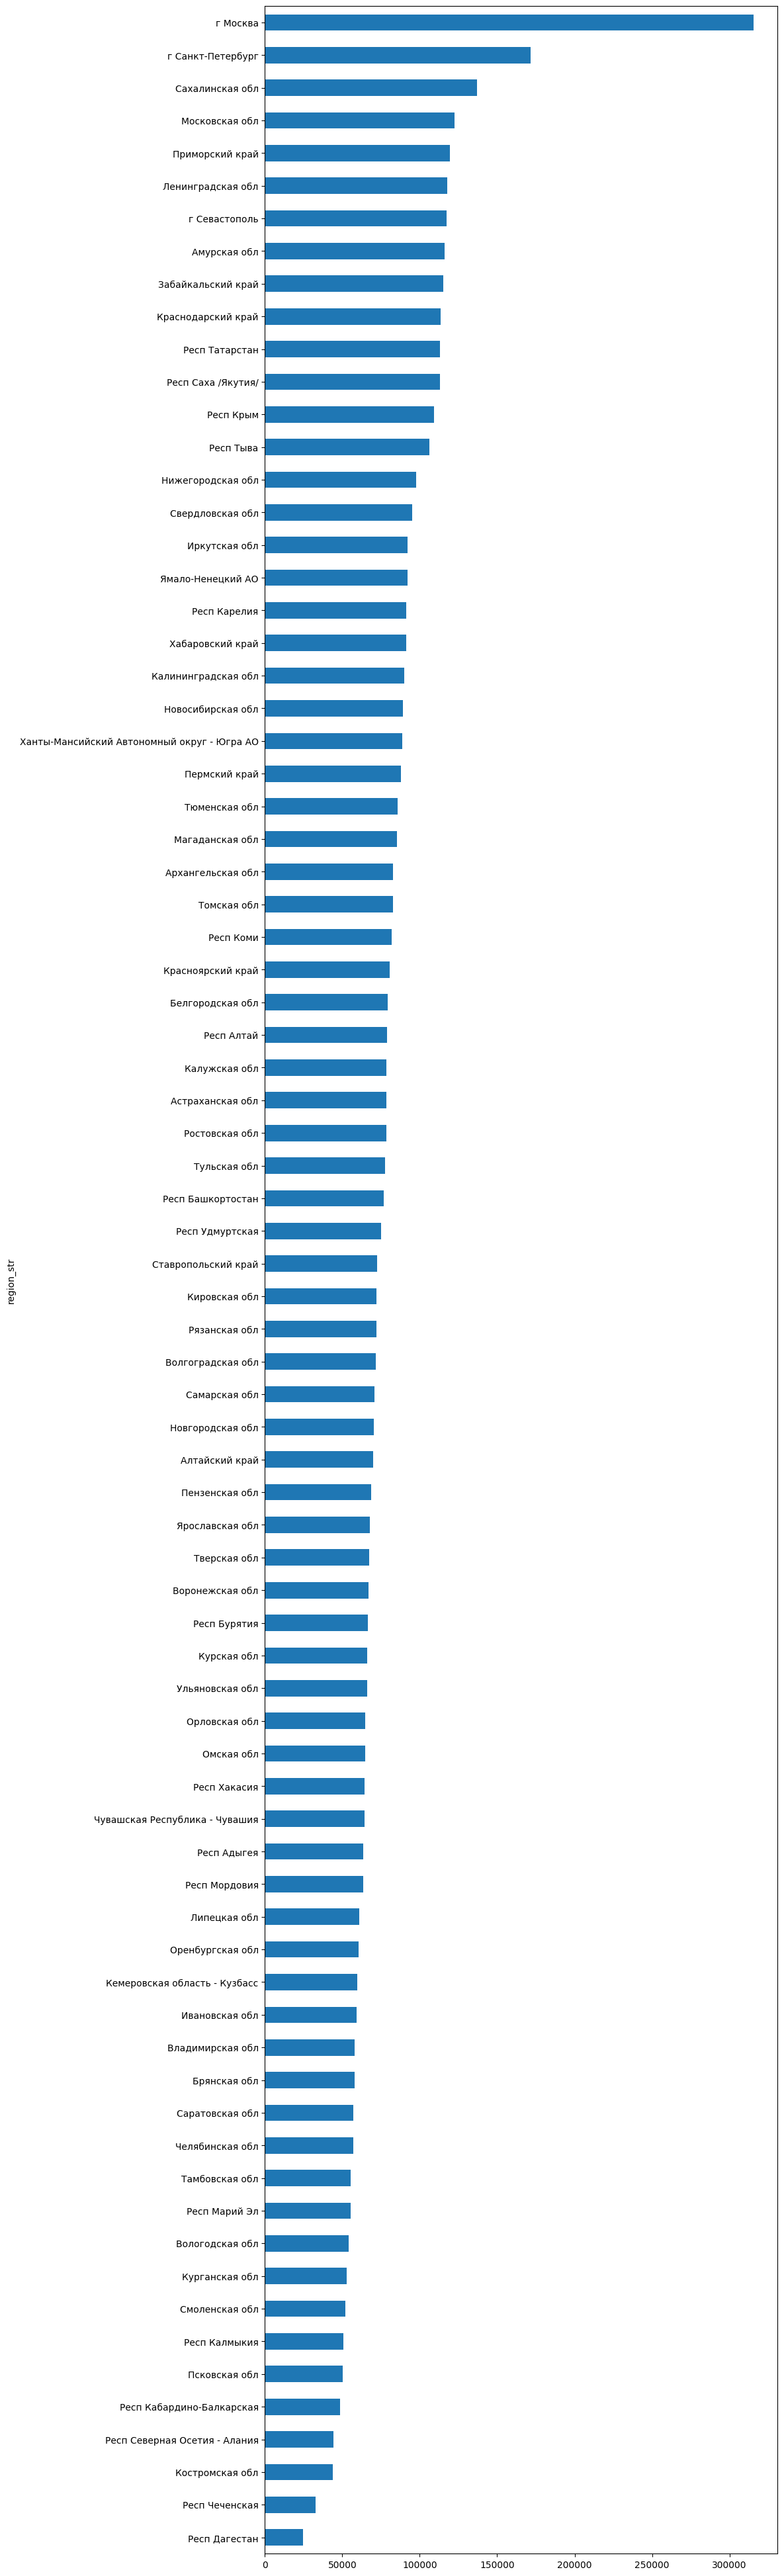

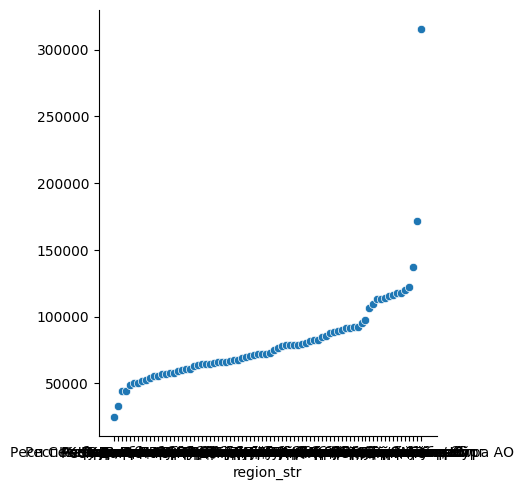

objSquareLiving


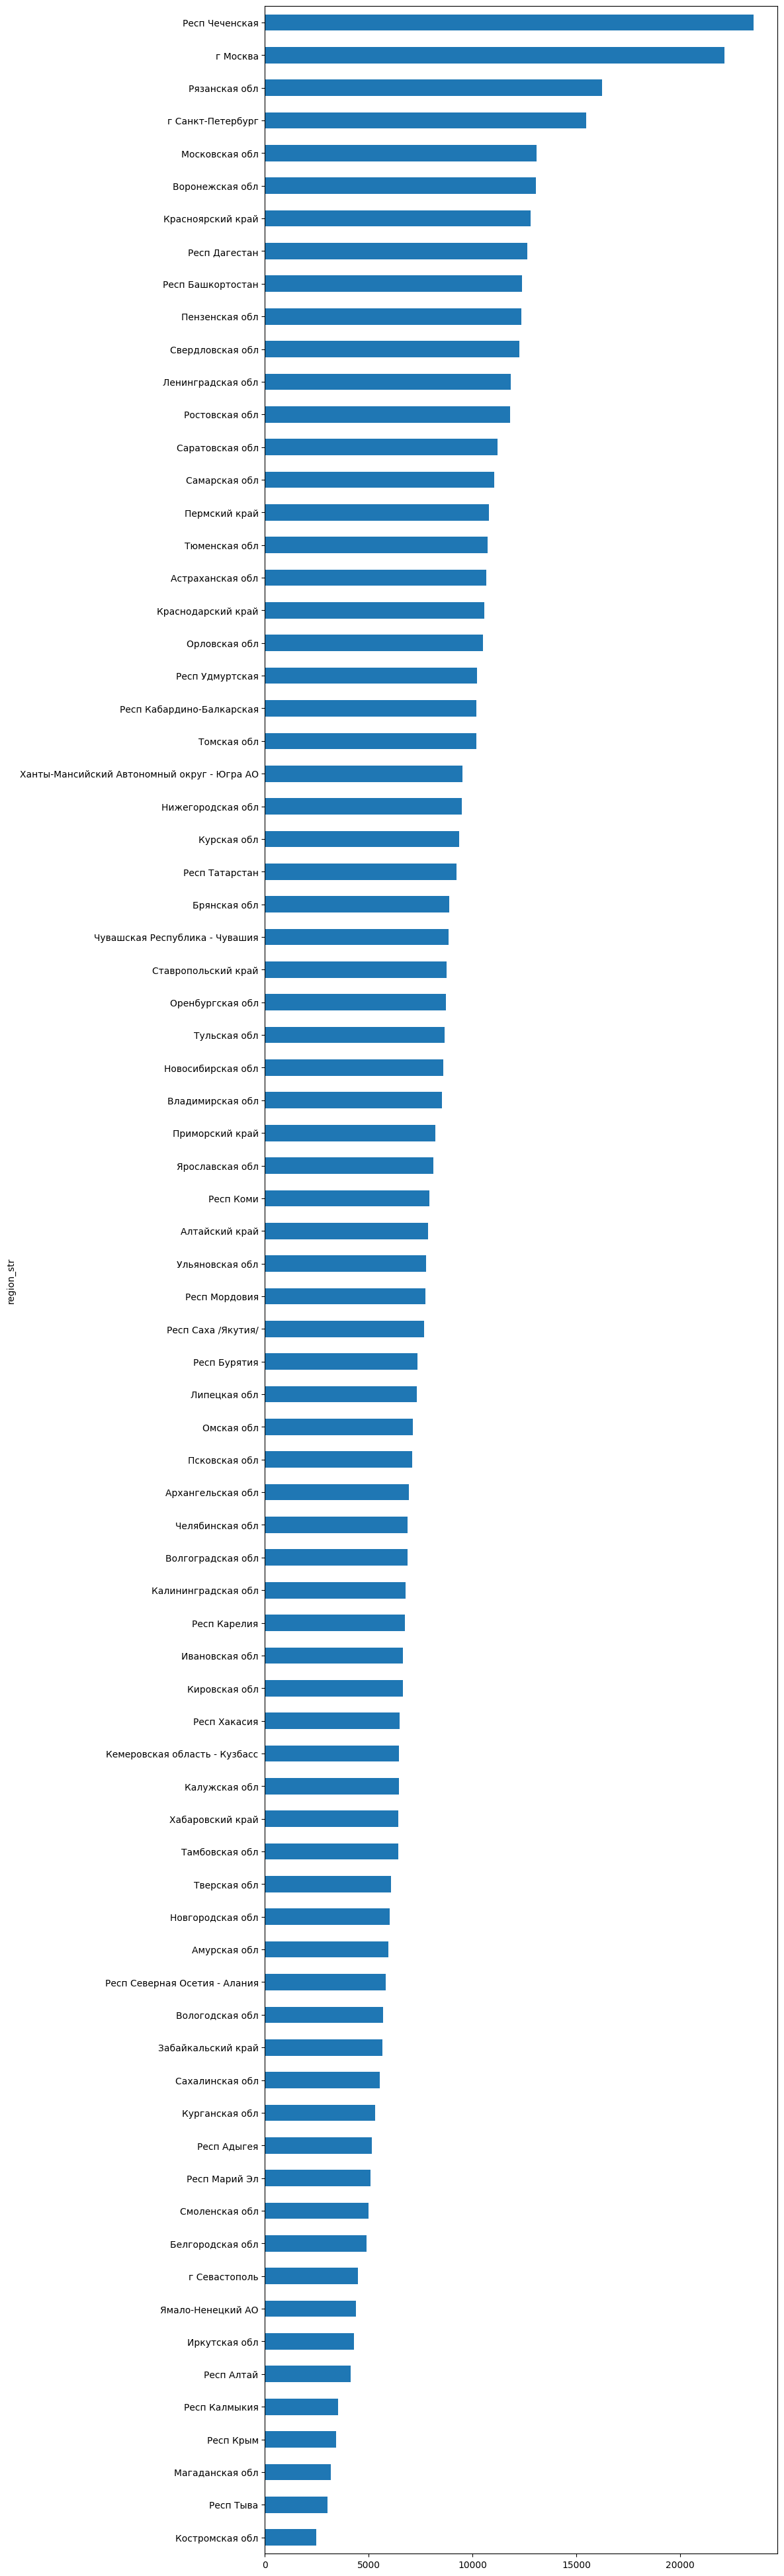

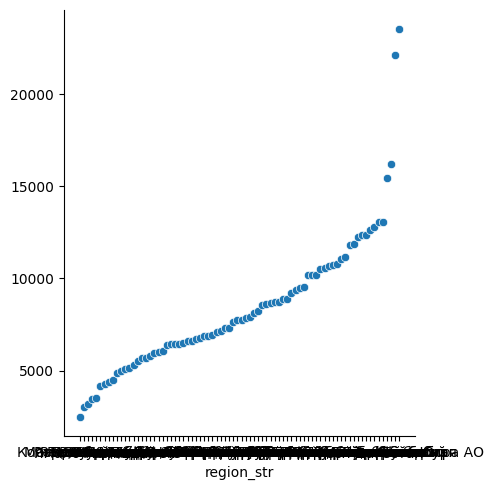

objElemParkingCnt


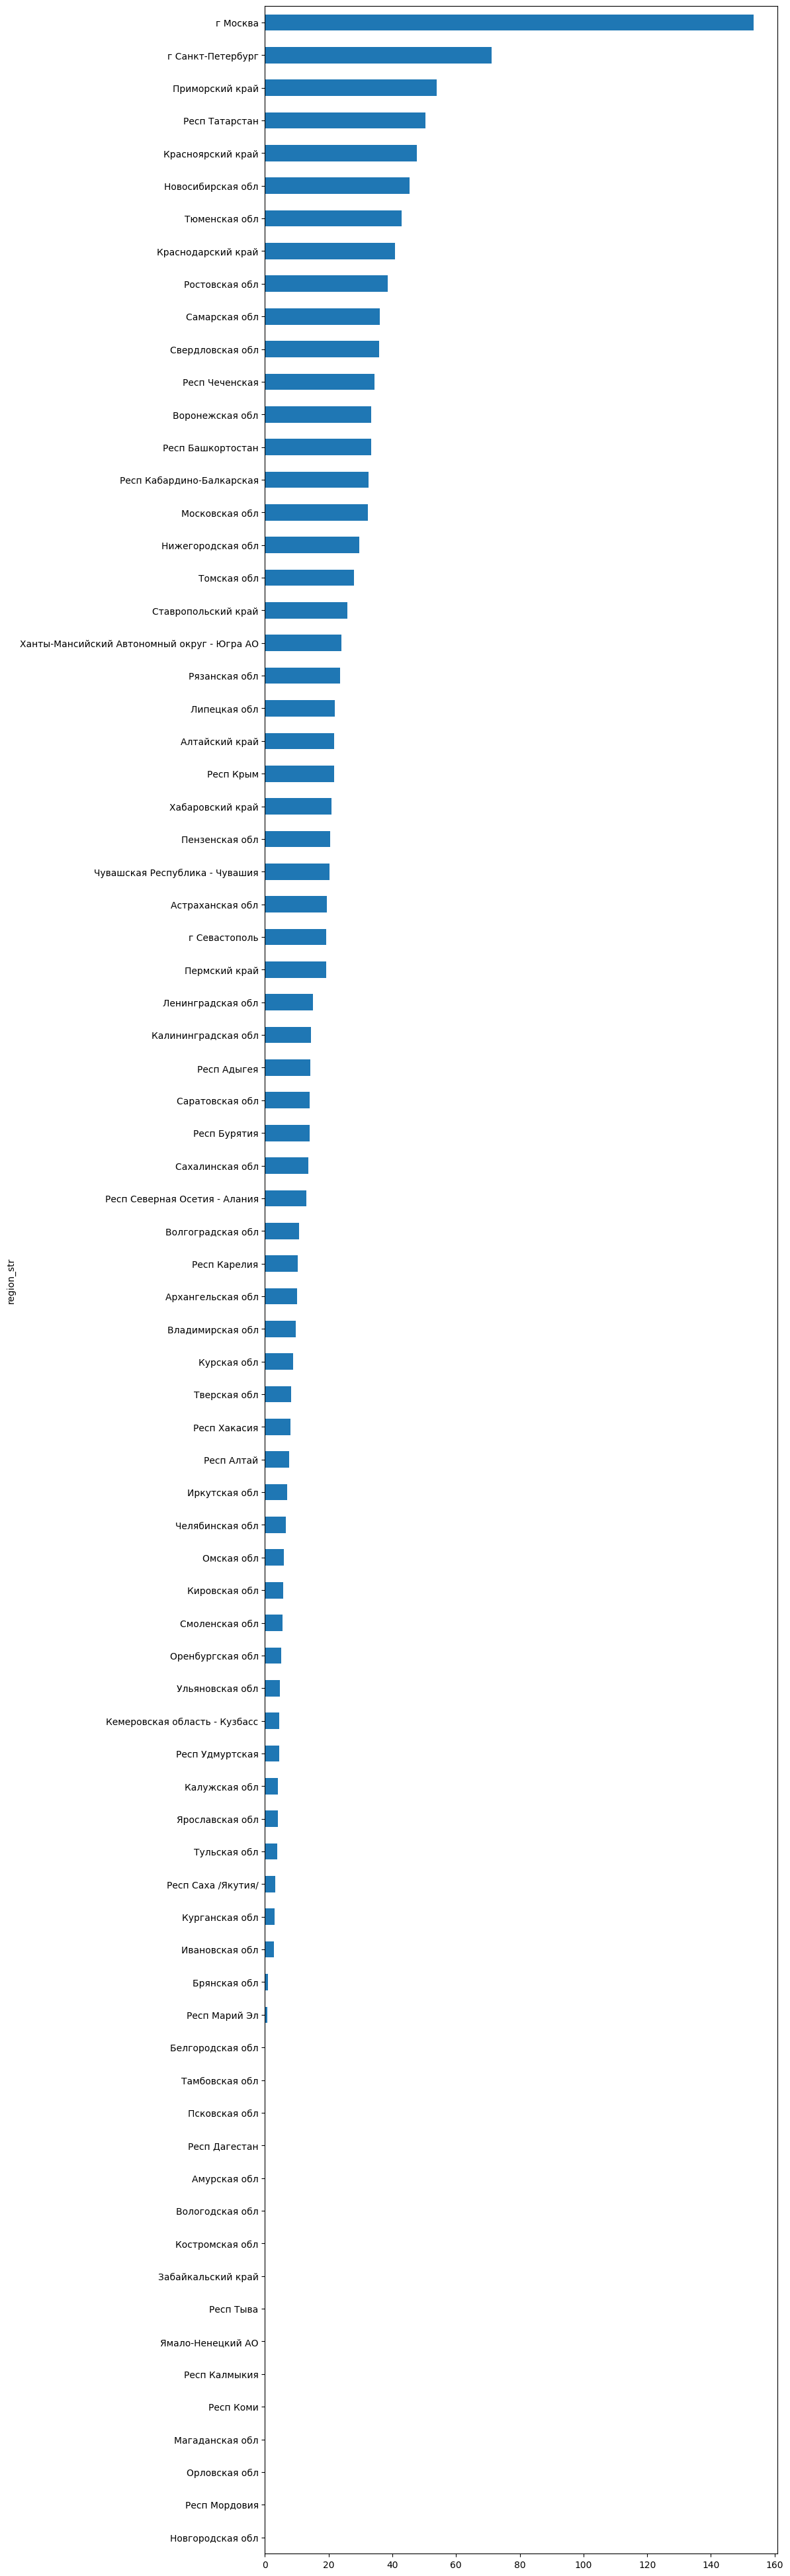

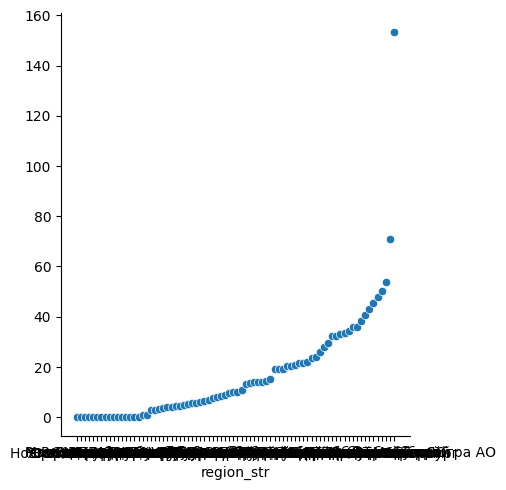

In [223]:
list_of_metrics = list()
list_of_metrics.extend([final_df.floorMax.name,final_df.objFlatCnt.name,final_df.objPriceAvg.name,final_df.objSquareLiving.name,final_df.objElemParkingCnt.name])
for t in list_of_metrics:
    print(t)
    a = final_df.pivot_table(columns = ['region_str'], values = [t], aggfunc='mean').mean()
    a = a.sort_values()
    a.plot.barh(figsize=(10, 50))
    sns.relplot(data=a)
    plt.show()

– Визуализировать разброс, связь и распределение этих показателей по регионам – Сделать выводы по каждому из расчетов и графиков